# Neural Networks and League of Legends

In this notebook, we take a look at what a NN is with a League of Legends dataset. Source code and additional resources are available at https://github.com/oracle-devrel/leagueoflegends-optimizer/tree/livelabs


This notebook creates a NN to make predictions based on pre-existing data (extracted using _`leagueoflegends-optimizer)`_.

## 1. Offline DataSet

Firstly, we'll explore the offline dataset that can be inferred from the _`https://REGION.api.riotgames.com/lol/match/v5/matches/ID`_ endpoint
    
Downloading data from professional games, we built the dataset called _`offline_dataset.csv`_. 
    
For each match, we have 5 matchups (5 players play against each other in different roles and different places in the map).
    
![](https://github.com/oracle-devrel/leagueoflegends-optimizer/raw/livelabs/hols/nn/model_building/images/matchups.png)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os
import pandas as pd
import oracledb
from sklearn.model_selection import train_test_split
import tensorflow as tf

from fastai.tabular.all import *

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Read CSV file

df = pd.read_csv('../../offline_dataset.csv',
                engine='python',
                index_col=[0])

df.head(5)

,goldEarned,totalMinionsKilled,win,kills,assists,deaths,champion,visionScore,puuid,totalDamageDealtToChampions,summonerName
0,5218,16,False,1,6,6,Bard,28,UNNl1KcPO98UoXiuRpQBefEKJbtCF_80b0_2s0Cwa5FiYia7CBuyoBqQwnvw6JDEIa8VDphv6wilow,4500,batata 12121212
1,7515,29,True,1,20,1,Blitzcrank,40,w2DLeo91qdfD72dpGgapMOKh_4IZ9IMF29neabiS0QTe8WAzWX4UtexFXLSjfuasgyjH2wQgagVXwg,7716,love yourseIf
2,9197,47,False,5,5,5,Nocturne,17,wDtmVguiopT93yrxtv2L88LxAVWC8E2fj_F3FDW81nCuSUffNCG0cQZJADKWx9GlJcQMuVWL_n9OBg,9696,NTM HACKER
3,10564,37,True,6,8,4,Kayn,12,zVKtTZrdKVIpXwIMlsuSQjwOgqxx0DMhnWDFL7MrAKxXZqZ8ksaJ9SVQ2Zjb-NrjQ4FB9LmDx-nx8w,15291,unsuri
4,10598,158,False,6,8,7,Pantheon,17,sTevUOXxKjNW7dpbtyu9wjn8KZxzN63_f2MfGc1EALDjtq7Z3JE0JZFvRtyuTjkGmbGPqMAEwvt0Hw,20568,Nome e Numeros


In [3]:
# Display available columns
df.columns

Index(['goldEarned', 'totalMinionsKilled', 'win', 'kills', 'assists', 'deaths',
       'champion', 'visionScore', 'puuid', 'totalDamageDealtToChampions',
       'summonerName'],
      dtype='object')

In [4]:
# Check out basic data
df.describe()

,goldEarned,totalMinionsKilled,kills,assists,deaths,visionScore,totalDamageDealtToChampions
count,1.000002e+06,1.000002e+06,1.000002e+06,1.000002e+06,1.000002e+06,1.000002e+06,1.000002e+06
mean,1.025516e+04,1.112703e+02,5.396888e+00,7.829310e+00,5.406309e+00,2.637145e+01,1.344311e+04
std,3.595263e+03,7.721071e+01,4.406000e+00,5.669173e+00,3.043000e+00,1.929329e+01,2.147520e+06
min,6.530000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.147484e+09
25%,7.691000e+03,3.200000e+01,2.000000e+00,4.000000e+00,3.000000e+00,1.400000e+01,8.291000e+03
50%,9.980000e+03,1.230000e+02,4.000000e+00,7.000000e+00,5.000000e+00,2.100000e+01,1.363700e+04
75%,1.255700e+04,1.740000e+02,8.000000e+00,1.100000e+01,7.000000e+00,3.200000e+01,2.071800e+04
max,3.274600e+04,5.070000e+02,4.800000e+01,5.200000e+01,3.200000e+01,2.590000e+02,1.185980e+05


In [5]:
if len(df.describe().columns) != len(df.columns):
    print('Categorical variables detected')
    
df.dtypes

Categorical variables detected


goldEarned                      int64
totalMinionsKilled              int64
win                              bool
kills                           int64
assists                         int64
deaths                          int64
champion                       object
visionScore                     int64
puuid                          object
totalDamageDealtToChampions     int64
summonerName                   object
dtype: object

In [6]:
# We see that we have 3 non-numerical variables: champion, puuid, summonerName
# puuid and summonerName are player identifiers -> will always vary for every player.

# We remove these two variables as we can't infer anything useful from ID columns in this case
def _drop_column(df, col_name=list()):
    for x in col_name:
        try:
            df.drop([x],
                axis=1,
                inplace=True)
        except KeyError:
            print('{} already dropped from df'.format(x))
        

    return df


df = _drop_column(df, ['puuid'])
df = _drop_column(df, ['summonerName'])

In [7]:
# We split our dataset into a percentage for training (80% in this case) and 20% for testing the model's performance
splitter = RandomSplitter(valid_pct=0.2, seed=777)
splits = splitter(range_of(df)) 

In [8]:
def _test_splitter(f, items=None):
    "A basic set of condition a splitter must pass"
    items = ifnone(items, range_of(30)) # create an array: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
    trn,val = f(items)
    assert 0<len(trn)<len(items)
    assert all(o not in val for o in trn)
    test_eq(len(trn), len(items)-len(val))
    # test random seed consistency
    test_eq(f(items)[0], trn)
    return trn, val

# We test our function
a = _test_splitter(splitter)
print('Testing splitting array with length of {}: {}'.format(
        len(range_of(30)),
        a
))
# we can modify this "splitting" function to our convenience and add custom rules.

Testing splitting array with length of 30: ([21, 2, 13, 0, 6, 23, 1, 16, 22, 18, 15, 29, 24, 27, 17, 9, 3, 20, 4, 11, 14, 26, 10, 12], [5, 28, 25, 8, 19, 7])


In [9]:
# Once we have our dataframe, we just have to mention:
# 1. Which variables are categorical (strings) and numerical (values) -> cat_names, cont_names
# 2. Which process do we want to apply to these variables -> procs=[]
# 3. Target feature to predict -> y_names
# 4. Type of problem (regression / classification) -> y_block = CategoryBlock() -> classification model
# 5. Batch size (for multiprocessing/concurrency) -> will load 'bs' number of rows at the same time


dls = TabularDataLoaders.from_df(
                df=df,
                procs=[Categorify, FillMissing, Normalize],
                cat_names = 'champion',
                cont_names = ['goldEarned', 'totalMinionsKilled',
                            'kills', 'assists', 'deaths', 'visionScore', 'totalDamageDealtToChampions'],
                y_names = 'win',
                y_block = CategoryBlock(),
                splits=splits,
                bs=64
)

In [10]:
# We take a look at 5 rows from our dataset
df.iloc[:5]

,goldEarned,totalMinionsKilled,win,kills,assists,deaths,champion,visionScore,totalDamageDealtToChampions
0,5218,16,False,1,6,6,Bard,28,4500
1,7515,29,True,1,20,1,Blitzcrank,40,7716
2,9197,47,False,5,5,5,Nocturne,17,9696
3,10564,37,True,6,8,4,Kayn,12,15291
4,10598,158,False,6,8,7,Pantheon,17,20568


In [11]:
# We show 10 dataloader's examples -> target variable at the end
dls.show_batch(max_n=10,
              show=True)

,champion,goldEarned,totalMinionsKilled,kills,assists,deaths,visionScore,totalDamageDealtToChampions,win
0,Samira,8969.999983,151.000001,5.000000e+00,3.0,9.0,15.0,10938.000011,True
1,Sett,9200.000041,122.000000,6.000000e+00,4.0,2.0,17.0,10827.000065,True
2,Nautilus,9533.000002,35.000000,1.000000e+00,19.0,11.0,84.0,10256.999885,True
3,Udyr,9353.999974,13.999997,3.000000e+00,5.0,5.0,22.0,7548.000253,False
4,Olaf,8401.000009,12.999996,6.000000e+00,4.0,6.0,13.0,8207.999916,False
5,Kayn,13645.000090,33.000001,1.800000e+01,3.0,5.0,13.0,25347.000348,True
6,Lucian,10237.000000,168.000001,6.000000e+00,5.0,5.0,19.0,17126.999864,False
7,Udyr,6512.999893,29.999996,-1.216320e-08,4.0,9.0,11.0,3772.000223,False
8,Kayn,9635.000009,44.000000,4.000000e+00,6.0,6.0,29.0,11336.999983,False
9,Seraphine,11671.000047,176.000000,4.000000e+00,18.0,4.0,14.0,12004.999988,True


In [12]:
# Test Visualization
idx = np.where((df['champion']=='Samira') & (df['kills']==11.0) & (df['visionScore']>50.0))
df.loc[idx]

,goldEarned,totalMinionsKilled,win,kills,assists,deaths,champion,visionScore,totalDamageDealtToChampions
114104,16329,268,False,11,10,2,Samira,57,16652
148217,16776,241,True,11,7,5,Samira,57,18522
322792,15370,231,False,11,5,8,Samira,58,23451
342764,17937,246,False,11,9,11,Samira,55,40135
454574,15650,167,False,11,11,8,Samira,65,24869
638252,16872,228,False,11,13,10,Samira,61,39625
892148,19588,247,False,11,14,10,Samira,53,44071
894953,14666,189,True,11,6,5,Samira,54,21822


In [13]:
# We create a NN learner
# since it's a classification problem, accuracy will measure the model's performance.
learn = tabular_learner(dls,
                        metrics=[accuracy])

SuggestedLRs(valley=0.001737800776027143)

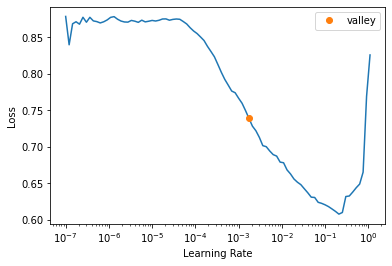

In [14]:
# We find the optimal Learning Rate -> other LRs can also work.
learn.lr_find()

In [15]:
# Train 50 epochs
learn.fit(50, lr=1e-3) # we use the learned LR from the cell above.

epoch,train_loss,valid_loss,accuracy,time
0,0.366879,0.355086,0.836055,01:49
1,0.364865,0.354328,0.836620,01:48
2,0.364106,0.356124,0.835640,01:50
3,0.357858,0.351069,0.838635,01:49
4,0.371946,0.353687,0.837595,01:48
5,0.369842,0.353015,0.837930,01:51
6,0.364620,0.351719,0.837985,01:52
7,0.358898,0.351688,0.837625,01:45
8,0.361396,0.351477,0.838135,01:47
9,0.365052,0.352252,0.838405,01:50


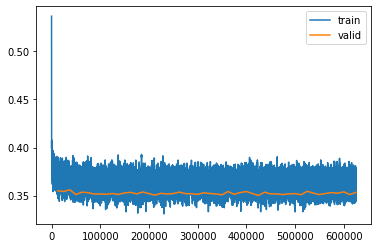

In [16]:
# We plot the observed loss 
learn.recorder.plot_loss()

In [17]:
# Show some predictions on df.
# Will show max_n samples and shuffle data (good to not always see the same rows)
learn.show_results(max_n=10, shuffle=True)

,champion,goldEarned,totalMinionsKilled,kills,assists,deaths,visionScore,totalDamageDealtToChampions,win,win_pred
0,43.0,1.748795,2.159838,0.816572,-0.499552,-0.791769,0.031828,0.001627,1.0,1.0
1,53.0,-1.185968,-1.219967,-0.998002,-0.499552,-0.463180,1.482815,-0.000667,0.0,0.0
2,15.0,-0.671731,-1.219967,0.362928,0.558010,-0.134590,-0.900949,0.002802,1.0,1.0
3,154.0,-0.441575,-1.232917,-0.998002,1.439312,-0.134590,2.726518,-0.002987,1.0,1.0
4,43.0,0.153271,1.085034,0.136106,-1.204594,1.179768,-0.745487,0.001221,0.0,0.0
5,51.0,-1.431690,-0.196961,-0.771181,-1.380854,-1.120359,-1.004591,-0.003926,0.0,0.0
6,139.0,-0.523575,-1.232917,-0.317537,-1.028333,0.194000,-0.486382,-0.001371,0.0,0.0
7,62.0,0.821501,0.800146,0.589750,-0.499552,-0.791769,-0.175456,0.004910,0.0,1.0
8,38.0,0.090729,0.554107,0.816572,-0.147031,-1.120359,-1.004591,0.000718,1.0,1.0
9,113.0,0.738667,1.110933,-0.317537,-0.852073,1.508358,-0.486382,0.004860,0.0,0.0


In [18]:
# Make test prediction
row, clas, probs = learn.predict(df.iloc[0])

print('Winning probability: {}%, losing probability: {}%'.format(probs[0].item(), probs[1].item()))

Winning probability: 0.9499648809432983%, losing probability: 0.05003509670495987%


## 2. Exploring Live Client DataSet + Data Points

In this second part of the notebook, we're going to focus on data that can be obtained from League of Legends **in real time**. Our data structure will be different, but it will help us create a "live companion" integration to help us while we're playing the game.

This dataset (_`live_client_dataset.csv`_) uses [this function](https://github.com/oracle-devrel/leagueoflegends-optimizer/blob/livelabs/src/league.py#L487) to download previous professional matches' timelines, with all kinds of events, and extracts. The Riot Games API endpoint used is _`https://MATCHID.api.riotgames.com/lol/match/v5/matches/REGION/timeline`_.
 
![](https://github.com/oracle-devrel/leagueoflegends-optimizer/blob/livelabs/hols/nn/model_building/images/liveclient.png?raw=True)
    
![](https://github.com/oracle-devrel/leagueoflegends-optimizer/blob/livelabs/hols/nn/model_building/images/predictor_liveclient.png?raw=True)

In [73]:
df = pd.read_csv('../../live_client_dataset.csv',
                engine='python',
                index_col=[0])

In [74]:
df.columns

Index(['winner', 'magicResist', 'healthRegenRate', 'spellVamp', 'timestamp',
       'bonusArmorPenetrationPercent', 'bonusMagicPenetrationPercent',
       'maxHealth', 'identifier', 'moveSpeed', 'attackDamage',
       'armorPenetrationPercent', 'lifesteal', 'abilityPower',
       'cooldownReduction', 'resourceValue', 'magicPenetrationFlat',
       'attackSpeed', 'currentHealth', 'armor', 'magicPenetrationPercent',
       'armorPenetrationFlat', 'resourceMax', 'resourceRegenRate'],
      dtype='object')

In [75]:
# Check out basic data
df.describe()

,winner,magicResist,healthRegenRate,spellVamp,timestamp,bonusArmorPenetrationPercent,bonusMagicPenetrationPercent,maxHealth,moveSpeed,attackDamage,...,cooldownReduction,resourceValue,magicPenetrationFlat,attackSpeed,currentHealth,armor,magicPenetrationPercent,armorPenetrationFlat,resourceMax,resourceRegenRate
count,500001.000000,500001.000000,500001.000000,500001.000000,5.000010e+05,500001.0,500001.0,500001.000000,500001.000000,500001.000000,...,500001.0,500001.000000,500001.000000,500001.000000,500001.000000,500001.000000,500001.000000,500001.0,500001.000000,500001.000000
mean,0.499873,45.165820,43.153188,0.053710,8.645540e+05,0.0,0.0,1372.862046,382.177646,122.677799,...,0.0,699.256013,2.221040,141.007356,1016.923710,69.196558,0.552875,0.0,889.096756,42.373071
std,0.500000,21.252961,98.990325,0.982707,5.577160e+05,0.0,0.0,617.430055,60.326677,75.767587,...,0.0,1283.671637,6.885666,44.483637,672.143125,39.065733,3.634704,0.0,1314.177384,49.653613
min,0.000000,-2.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,340.000000,0.000000,25.000000,...,0.0,0.000000,0.000000,51.000000,0.000000,-14.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,33.000000,16.000000,0.000000,4.201020e+05,0.0,0.0,891.000000,345.000000,73.000000,...,0.0,248.000000,0.000000,112.000000,561.000000,45.000000,0.000000,0.0,400.000000,17.000000
50%,0.000000,38.000000,23.000000,0.000000,8.402250e+05,0.0,0.0,1291.000000,375.000000,93.000000,...,0.0,444.000000,0.000000,125.000000,947.000000,59.000000,0.000000,0.0,638.000000,26.000000
75%,1.000000,47.000000,35.000000,0.000000,1.260431e+06,0.0,0.0,1718.000000,395.000000,155.000000,...,0.0,749.000000,0.000000,154.000000,1433.000000,81.000000,0.000000,0.0,955.000000,49.000000
max,1.000000,492.000000,7806.000000,37.000000,3.065997e+06,0.0,0.0,7019.000000,1151.000000,936.000000,...,0.0,10080.000000,50.000000,621.000000,6921.000000,1308.000000,52.000000,0.0,10080.000000,1158.000000


In [76]:
if len(df.describe().columns) != len(df.columns):
    print('Categorical variables detected')
    
df.dtypes

Categorical variables detected


winner                           int64
magicResist                      int64
healthRegenRate                  int64
spellVamp                        int64
timestamp                        int64
bonusArmorPenetrationPercent     int64
bonusMagicPenetrationPercent     int64
maxHealth                        int64
identifier                      object
moveSpeed                        int64
attackDamage                     int64
armorPenetrationPercent          int64
lifesteal                        int64
abilityPower                     int64
cooldownReduction                int64
resourceValue                    int64
magicPenetrationFlat             int64
attackSpeed                      int64
currentHealth                    int64
armor                            int64
magicPenetrationPercent          int64
armorPenetrationFlat             int64
resourceMax                      int64
resourceRegenRate                int64
dtype: object

In [77]:
# drop columns we don't want (constant values + identifier)

# Drop categorical identifying variable

df = _drop_column(df, ['identifier'])
df = _drop_column(df, ['bonusArmorPenetrationPercent', 'bonusMagicPenetrationPercent',
                 'cooldownReduction', 'armorPenetrationFlat'])

label = 'winner'

In [78]:
df.iloc[:5] # == df.head(5)

,winner,magicResist,healthRegenRate,spellVamp,timestamp,maxHealth,moveSpeed,attackDamage,armorPenetrationPercent,lifesteal,abilityPower,resourceValue,magicPenetrationFlat,attackSpeed,currentHealth,armor,magicPenetrationPercent,resourceMax,resourceRegenRate
0,0,67,130,0,1080369,1738,375,164,0,0,0,535,0,139,1209,68,0,795,89
1,0,44,29,0,1080369,1695,467,89,0,0,297,364,0,295,403,87,0,621,94
2,0,42,76,0,1080369,1419,242,89,0,0,115,619,18,122,846,52,0,1222,57
3,0,33,14,0,1080369,1194,385,160,0,0,0,222,0,208,0,51,0,467,19
4,0,33,30,0,1080369,1323,375,67,0,0,40,19,0,125,451,59,0,870,45


In [79]:
print(df.dtypes)

winner                     int64
magicResist                int64
healthRegenRate            int64
spellVamp                  int64
timestamp                  int64
maxHealth                  int64
moveSpeed                  int64
attackDamage               int64
armorPenetrationPercent    int64
lifesteal                  int64
abilityPower               int64
resourceValue              int64
magicPenetrationFlat       int64
attackSpeed                int64
currentHealth              int64
armor                      int64
magicPenetrationPercent    int64
resourceMax                int64
resourceRegenRate          int64
dtype: object


In [80]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df)) # 80-20 split

dls = TabularDataLoaders.from_df(df=df,
                   procs=[Categorify, FillMissing, Normalize],
                   cat_names = None,
                   cont_names = ['magicResist', 'healthRegenRate', 'spellVamp', 'timestamp',
                                 'maxHealth', 'moveSpeed', 'attackDamage', 'armorPenetrationPercent',
                                 'lifesteal', 'abilityPower', 'resourceValue', 'magicPenetrationFlat',
                                 'attackSpeed', 'currentHealth', 'armor', 'magicPenetrationPercent',
                                 'resourceMax', 'resourceRegenRate'],
                    y_names=label,
                    y_block = CategoryBlock([0.0, 1.0]),
                    splits=splits,
                    bs=64)

In [81]:
dls.show_batch(max_n=10, show=True)

,magicResist,healthRegenRate,spellVamp,timestamp,maxHealth,moveSpeed,attackDamage,armorPenetrationPercent,lifesteal,abilityPower,resourceValue,magicPenetrationFlat,attackSpeed,currentHealth,armor,magicPenetrationPercent,resourceMax,resourceRegenRate,winner
0,49.0,34.0,-1.364599e-09,1.680555e+06,1611.999991,385.0,382.000006,20.0,-5.644251e-08,0.000002,1764.999966,8.438601e-08,132.0,1612.000003,88.0,1.614056e-08,1874.000011,45.0,1.0
1,49.0,34.0,-1.364599e-09,1.680555e+06,1611.999991,385.0,382.000006,20.0,-5.644251e-08,0.000002,1764.999966,8.438601e-08,132.0,1612.000003,88.0,1.614056e-08,1874.000011,45.0,1.0
2,49.0,34.0,-1.364599e-09,1.680555e+06,1611.999991,385.0,382.000006,20.0,-5.644251e-08,0.000002,1764.999966,8.438601e-08,132.0,1612.000003,88.0,1.614056e-08,1874.000011,45.0,1.0
3,49.0,34.0,-1.364599e-09,1.680555e+06,1611.999991,385.0,382.000006,20.0,-5.644251e-08,0.000002,1764.999966,8.438601e-08,132.0,1612.000003,88.0,1.614056e-08,1874.000011,45.0,1.0
4,49.0,34.0,-1.364599e-09,1.680555e+06,1611.999991,385.0,382.000006,20.0,-5.644251e-08,0.000002,1764.999966,8.438601e-08,132.0,1612.000003,88.0,1.614056e-08,1874.000011,45.0,1.0
5,49.0,34.0,-1.364599e-09,1.680555e+06,1611.999991,385.0,382.000006,20.0,-5.644251e-08,0.000002,1764.999966,8.438601e-08,132.0,1612.000003,88.0,1.614056e-08,1874.000011,45.0,1.0
6,49.0,34.0,-1.364599e-09,1.680555e+06,1611.999991,385.0,382.000006,20.0,-5.644251e-08,0.000002,1764.999966,8.438601e-08,132.0,1612.000003,88.0,1.614056e-08,1874.000011,45.0,1.0
7,49.0,34.0,-1.364599e-09,1.680555e+06,1611.999991,385.0,382.000006,20.0,-5.644251e-08,0.000002,1764.999966,8.438601e-08,132.0,1612.000003,88.0,1.614056e-08,1874.000011,45.0,1.0
8,49.0,34.0,-1.364599e-09,1.680555e+06,1611.999991,385.0,382.000006,20.0,-5.644251e-08,0.000002,1764.999966,8.438601e-08,132.0,1612.000003,88.0,1.614056e-08,1874.000011,45.0,1.0
9,49.0,34.0,-1.364599e-09,1.680555e+06,1611.999991,385.0,382.000006,20.0,-5.644251e-08,0.000002,1764.999966,8.438601e-08,132.0,1612.000003,88.0,1.614056e-08,1874.000011,45.0,1.0


In [82]:
learn = tabular_learner(dls,
    layers=[1000, 500, 250],
    metrics=[accuracy]
)

SuggestedLRs(valley=0.00019054606673307717)

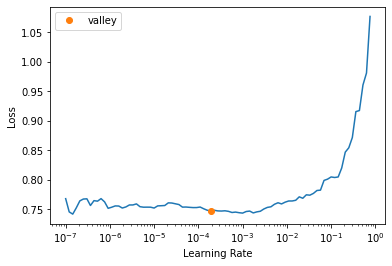

In [83]:
learn.lr_find()

In [84]:
learn.summary()

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 18             
BatchNorm1d                               36         True      
____________________________________________________________________________
                     64 x 1000           
Linear                                    18000      True      
ReLU                                                           
BatchNorm1d                               2000       True      
____________________________________________________________________________
                     64 x 500            
Linear                                    500000     True      
ReLU                                                           
BatchNorm1d                               1000       True      
____________________________________________________________________________
                     64 x 250            
Linear                                    125000     T

In [85]:
learn.fit(150,
          lr=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.670350,0.667496,0.584250,01:36
1,0.662091,0.663458,0.589520,01:38
2,0.668712,0.661215,0.591900,01:41
3,0.662227,0.659039,0.591350,01:32
4,0.658192,0.658635,0.592920,01:39
5,0.665612,0.658516,0.593350,01:40
6,0.659263,0.658438,0.592030,01:41
7,0.659378,0.657680,0.594410,01:37
8,0.655144,0.657200,0.594600,01:36
9,0.656615,0.655446,0.596680,01:32


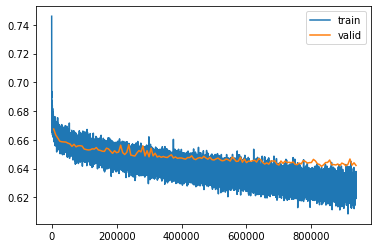

In [86]:
learn.recorder.plot_loss()

In [87]:
learn.show_results()

,magicResist,healthRegenRate,spellVamp,timestamp,maxHealth,moveSpeed,attackDamage,armorPenetrationPercent,lifesteal,abilityPower,resourceValue,magicPenetrationFlat,attackSpeed,currentHealth,armor,magicPenetrationPercent,resourceMax,resourceRegenRate,winner,winner_pred
0,-0.713576,-0.223217,-0.054776,-1.119768,-0.964745,-0.782061,-0.669831,-0.202233,-0.350645,-0.506972,-0.311432,-0.322606,-0.608142,-0.549199,-0.796792,-0.152168,-0.368689,-0.490305,1.0,0.0
1,-0.055037,-0.071878,-0.054776,-0.796897,-0.453073,-0.201323,0.188832,-0.202233,-0.112988,-0.506972,-0.544213,-0.322606,-0.181139,-0.148982,-0.618023,-0.152168,-0.599836,-0.852759,1.0,1.0
2,-0.525422,-0.263574,-0.054776,1.305009,0.651233,0.296452,0.505877,1.755923,-0.350645,-0.506972,-0.274062,-0.322606,1.189765,-1.513289,-0.030640,2.602513,-0.072911,0.375557,0.0,0.0
3,-0.149114,0.977404,-0.054776,-0.474174,-0.519461,-0.085176,-0.247105,-0.202233,2.025923,-0.506972,-0.049066,-0.322606,0.133495,-0.623588,-0.490331,-0.152168,-0.187725,2.550281,1.0,0.0
4,-0.572460,-0.253485,-0.054776,0.817007,0.184899,3.714510,-0.616990,-0.202233,-0.350645,1.800154,0.614245,-0.322606,-0.787933,0.699060,-0.464793,-0.152168,0.455534,0.214467,0.0,0.0
5,0.180156,1.895526,-0.054776,0.279125,1.256820,-1.362799,0.941814,-0.202233,-0.350645,-0.506972,0.158024,-0.322606,-0.405878,-0.653344,-0.158332,-0.152168,0.140748,-0.852759,0.0,0.0
6,-0.525422,2.551327,-0.054776,0.817290,0.223760,-0.035398,-0.511309,-0.202233,-0.350645,2.969236,1.383437,3.884518,-0.495773,0.734767,-0.234947,-0.152168,1.247061,5.872776,1.0,1.0
7,1.873541,-0.031521,-0.054776,0.063986,0.008404,-0.035398,-0.603780,-0.202233,-0.350645,-0.403513,-0.034274,-0.322606,-0.338456,0.536891,1.373974,-0.152168,-0.156550,-0.429896,0.0,0.0
8,-0.666537,-0.303931,-0.054776,-0.689283,-0.673286,-0.947986,-0.524519,-0.202233,0.124668,-0.506972,-0.141711,-0.322606,0.627919,-0.849733,-0.669100,-0.152168,0.072316,-0.409760,0.0,0.0


In [88]:
row, clas, probs = learn.predict(df.iloc[0])

In [89]:
print('Winning probability: {}%, losing probability: {}%'.format(probs[0].item(), probs[1].item()))

Winning probability: 0.6967057585716248%, losing probability: 0.30329421162605286%


## Adding Model Robustness - 

### Aggregating Results in a Sliding Time Window

The idea is that, in a live match, we have timestamped data that isn't completely independent from previous rows; if you're having a bad game, it's very likely enemies will be able to capitalize on your mistakes and gain even more advantage.

Therefore, we should consider a sliding time window like this:

![](https://github.com/oracle-devrel/leagueoflegends-optimizer/blob/livelabs/hols/nn/model_building/images/sliding_window.jpg?raw=True)

And make our predictions in batches of n timed events.

In [90]:
# To add some robustness to our model, we can make 10 predictions
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
ds_aggregator = list()

for x in range(10):
    row, clas, probs = learn.predict(df.sort_values(by=['timestamp']).iloc[x])
    del row, clas
    ds_aggregator.append(probs[0].item()) # aggregate winning probabilities

import statistics
result = statistics.mean(ds_aggregator)

print('Combined weighted winning probability: {}'.format(result))

Combined weighted winning probability: 0.49169673919677737


# Exporting/Importing Models

Inference on a test set:

We'll bring an exported model to show that you don't need original data (used to train and test the model) locally to work with models after this training is complete.

In [91]:
learn.export('liveclient_model')

del learn

learn = load_learner('liveclient_model')


'''Now we generate our test_dl from our test_df'''
dl = learn.dls.test_dl(df)

'''

We need to tell the Learner to return the predictions for the test set we added
'''


raw_test_preds = learn.get_preds(dl=dl)

In [92]:
'''You'll notice [0] contains our predictions, and [1] contains any labels (if we had any).'''

raw_test_preds

(tensor([[0.6967, 0.3033],
         [0.3967, 0.6033],
         [0.5271, 0.4729],
         ...,
         [0.5506, 0.4494],
         [0.6431, 0.3569],
         [0.3813, 0.6187]]),
 tensor([[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [1]], dtype=torch.int8))

In [93]:
learn.validate(dl=dl)

(#2) [0.6154924035072327,0.6447027325630188]

In [94]:
test_preds = raw_test_preds[0].numpy().T[0]

print(test_preds)

[0.6967058  0.39672744 0.5271295  ... 0.5505954  0.6431331  0.3813127 ]


In [95]:
'''
Permutation importance is a technique in which we shuffle
each column in a dataframe and analyze how changing a particular
column affected our y values. The more that it was affected,
the more "important" we can (generally) call a variable in our
neural network.
Let's build a quick algorithm to do this:
'''

class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df
    bs = bs if bs is not None else learn.dls.bs
    if self.df is not None:
      self.dl = learn.dls.test_dl(self.df, bs=bs)
    else:
      self.dl = learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))
    


Getting base error


Calculating Permutation Importance


{'magicResist': 0.039872371905620464,
 'healthRegenRate': 0.012759101971858621,
 'spellVamp': 0.0,
 'timestamp': 0.19936204965456872,
 'maxHealth': 0.14513550978704504,
 'moveSpeed': 0.020733576352982713,
 'attackDamage': 0.13078143688837504,
 'armorPenetrationPercent': 0.0015948758635781764,
 'lifesteal': -0.023923518206605487,
 'abilityPower': 0.06220091918541456,
 'resourceValue': 0.044657094559588204,
 'magicPenetrationFlat': 0.015948948762248186,
 'attackSpeed': 0.044657094559588204,
 'currentHealth': 0.009569350244702268,
 'armor': 0.06858051770296048,
 'magicPenetrationPercent': 0.006379503454312705,
 'resourceMax': 0.019138700489404536,
 'resourceRegenRate': 0.05741619653144682}

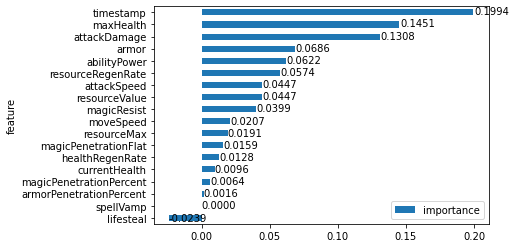

In [96]:
# And now we can simply call PermutationImportance to run it!
res = PermutationImportance(learn, df.iloc[:1000], bs=64)

res.importance